In [1]:
!git clone https://github.com/autonomousvision/stylegan_xl.git
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja
!pip install timm

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 298 (delta 69), reused 48 (delta 48), pack-reused 216
Receiving objects: 100% (298/298), 13.88 MiB | 5.97 MiB/s, done.
Resolving deltas: 100% (140/140), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 239 (delta 0), reused 2 (delta 0), pack-reused 236
Receiving objects: 100% (239/239), 8.92 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/CLIP
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 919.1 kB/s eta 0:00:00
  Running setup.py develop for clip
Looking in indexes: https://pypi.org/simple, https

In [2]:
import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan_xl')

import numpy as np
import torch
import torch.nn as nn
import tensorflow as tf
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim

import dnnlib
import legacy
from torch_utils import gen_utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load in the trained StyleganXL model
network_pkl = "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet1024.pkl"
with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema']
        G = G.eval().requires_grad_(False).to(device)
c = None

In [29]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def get_latents(amount, seed, shape = 512):
    latents = torch.from_numpy(np.random.RandomState(seed).randn(amount, shape)).cuda()
    w = torch.empty(amount, 16, shape)
    for i in range(latents.shape[0]):
        w[i] = G.mapping(latents[i][None], c)
    return latents, w

def img_from_latent(net, latents, img_size, show_img = False, outdir = None):
    outputs = torch.empty((len(latents), 3, img_size, img_size))
    transform=transforms.Compose([transforms.Resize(img_size),transforms.CenterCrop(img_size),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    for i, latent in enumerate(latents):
        img = gen_utils.w_to_img(net, latent, to_np=True)
        img = Image.fromarray(img[0], 'RGB')
        img = img.resize((img_size,img_size), resample = PIL.Image.LANCZOS)
        if show_img:
            plt.axis('off')
            plt.title("Image "+str(i))
            plt.imshow(img)
            plt.show()
        if not outdir == None:
          img.save(outdir + "Image %d.svg" % i)
        img = transform(img)
        outputs[i] = img
    return outputs

def train(netD, netG, num_iters, batch_size, img_size, seed, criterion, optimizer):
    losses = []
    for i in range(num_iters):
        w = gen_utils.get_w_from_seed(G, batch_size, device, seed = np.random.seed(seed))
        w = w.to(device) # naar float32?
        x = img_from_latent(netG, w, img_size).to(device)

        netD.zero_grad()

        output = netD(x).squeeze()

        errD = criterion(output, w[:,0])
        errD.backward()
        optimizer.step()
        
        if i % 5 == 0:
          print('[%d/%d]\tLoss_D: %.4f' % (i+1, num_iters, errD.item()))

        losses.append(errD.item())

    return losses

In [30]:
class Discriminator(nn.Module):
    def __init__(self, channels = 3, feature_maps = 64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_maps * 8, 512, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

[0.5408791303634644, 0.5905948281288147, 0.5478622913360596, 0.5326316952705383, 0.4843047261238098, 0.456355482339859, 0.4507354497909546]


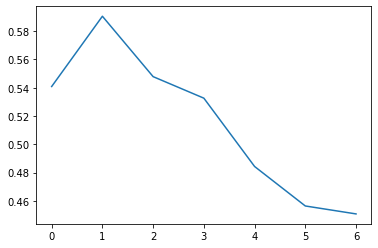

In [16]:
print(losses)
plt.plot(losses)

In [24]:
netD_imagenet1024_2000 = Discriminator().to(device)
optimizerD_Adam_W = optim.Adam(netD_imagenet1024_2000.parameters(), lr=0.0002)

checkpoint = torch.load('/content/drive/MyDrive/Internship/internship-transfer-files/intermediate_results/netD_imagenet1024_w_2000.pt')
netD_imagenet1024_2000.load_state_dict(checkpoint['model_state_dict'])
optimizerD_Adam_W.load_state_dict(checkpoint['optimizer_state_dict'])
iter = checkpoint['iter']
loss = checkpoint['loss']

netD_imagenet1024_2000.eval()
print(iter)

2000


In [31]:
seed = 42
outdir = '/content/drive/MyDrive/Internship/results/imagenet1024/'
os.makedirs(outdir, exist_ok=True)
batch_sz = 10

w = gen_utils.get_w_from_seed(G, batch_sz, device, seed=seed)
w = w.to(device)
print(w.shape)

outputs = img_from_latent(G, w, 64).to(device)
highq_outputs = img_from_latent(G, w, 1024, outdir=outdir+"Original_").to(device)

torch.Size([10, 39, 512])


ValueError: ignored

In [26]:
netD_imagenet1024_2000.zero_grad()
new_w = netD_imagenet1024_2000(outputs).squeeze()
print(new_w.shape)
new_w_reshaped = new_w[:,None,:].repeat(1,39,1)
print(new_w_reshaped.shape)

torch.Size([10, 512])
torch.Size([10, 39, 512])


In [27]:
loss = nn.MSELoss()(new_w_reshaped, w)
loss

tensor(0.5350, device='cuda:0', grad_fn=<MseLossBackward0>)

In [28]:
outdir = '/content/drive/MyDrive/Internship/results/imagenet1024/Recon_2000_'
new_outputs = img_from_latent(G, new_w_reshaped.detach(), 1024, outdir=outdir).to(device)

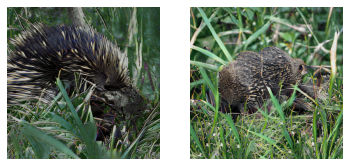

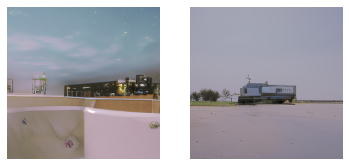

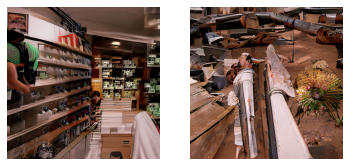

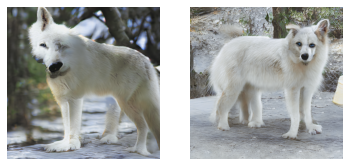

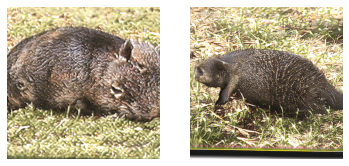

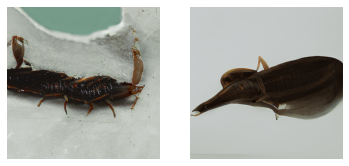

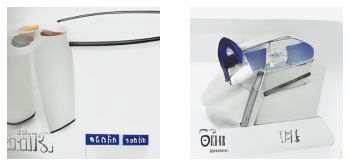

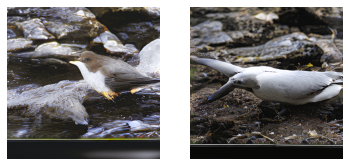

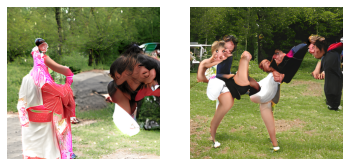

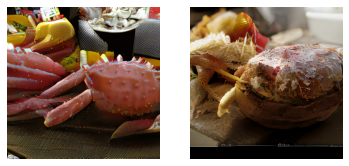

In [ ]:
for i in range(10):
    _, axs = plt.subplots(1, 2)
    axs = axs.flatten()
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/imagenet1024/Original_Image %d.png" % i)
    axs[0].imshow(img)
    axs[0].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/imagenet1024/Recon_40000_Image %d.png" % i)
    axs[1].imshow(img)
    axs[1].axis('off')
    plt.show()

In [ ]:
netD_imagenet1024_10000 = Discriminator().to(device)
optimizerD_Adam_W = optim.Adam(netD_imagenet1024_10000.parameters(), lr=0.0002)

checkpoint = torch.load('/content/drive/MyDrive/Internship/internship-transfer-files/intermediate_results/netD_imagenet1024_w_10000.pt')
netD_imagenet1024_10000.load_state_dict(checkpoint['model_state_dict'])
optimizerD_Adam_W.load_state_dict(checkpoint['optimizer_state_dict'])
iter = checkpoint['iter']
loss = checkpoint['loss']

netD_imagenet1024_10000.eval()
print(iter)

10000


In [ ]:
netD_imagenet1024_10000.zero_grad()
new_w = netD_imagenet1024_10000(outputs).squeeze()
print(new_w.shape)
new_w_reshaped = new_w[:,None,:].repeat(1,39,1)
print(new_w_reshaped.shape)

torch.Size([10, 512])
torch.Size([10, 39, 512])


In [ ]:
loss = nn.MSELoss()(new_w_reshaped, w)
loss

tensor(0.4879, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
outdir = '/content/drive/MyDrive/Internship/results/imagenet1024/Recon_10000_'
new_outputs = img_from_latent(G, new_w_reshaped.detach(), 1024, outdir=outdir).to(device)

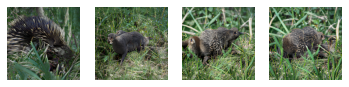

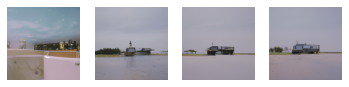

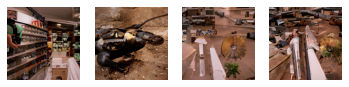

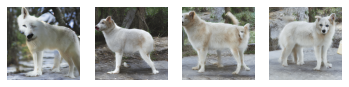

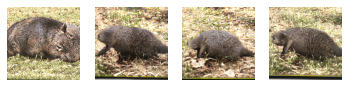

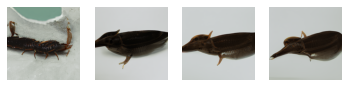

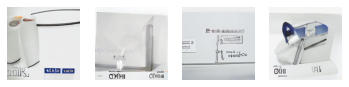

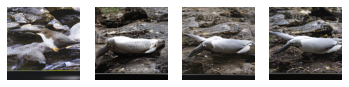

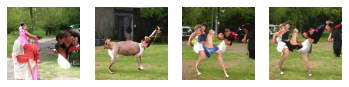

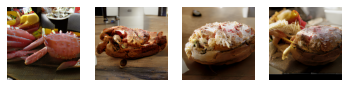

In [ ]:
for i in range(10):
    _, axs = plt.subplots(1, 4)
    axs = axs.flatten()
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/imagenet1024/Original_Image %d.png" % i)
    axs[0].imshow(img)
    axs[0].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/imagenet1024/Recon_10000_Image %d.png" % i)
    axs[1].imshow(img)
    axs[1].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/imagenet1024/Recon_30000_Image %d.png" % i)
    axs[2].imshow(img)
    axs[2].axis('off')
    img = mpimg.imread("/content/drive/MyDrive/Internship/results/imagenet1024/Recon_40000_Image %d.png" % i)
    axs[3].imshow(img)
    axs[3].axis('off')
    plt.show()